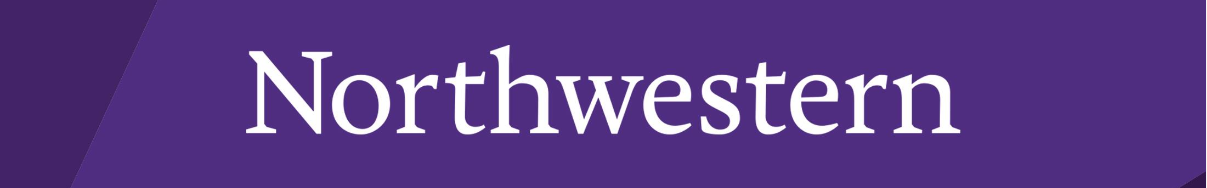

##CHEST XRAY IMAGE CAPTIONING
This research effort aims to generate reports of chest X-Rays initially using pre-trained models to perform description extraction and then using that info to generate caption using LSTMs and GRUs. The dataset being used is publicly available from Indiana University and consists of chest X-ray images and reports. The goal is to predict the physician's notes of the information associated with the image.



##Dataset Overview
The Chest X-ray dataset from Indiana University has two sets of files, one contains an X-ray image of patients, and the other includes radiology reports of that particular patient in XML format (https://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d). The report could be associated with more than one image. The XML fields are image_id, the caption of an image, indication of patient, findings, and impression. There are 7471 X-ray images and 3955 reports in the dataset. The impression is the target feature.

##Import packages

In [1]:
#Ignore Warning
import warnings
warnings.filterwarnings("ignore") 
# set up notebook to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import datetime
from packaging import version
import tarfile
from collections import Counter
import numpy as np
import pandas as pd
import time
import string
import os # Operation System
from tqdm import tqdm
import xml.etree.ElementTree as et

from timeit import default_timer as timer
import time
from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS# to visualize wordcloud
import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.layers import TextVectorization

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow version and Keras version

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2
print("Keras version: ", keras.__version__)

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0
Keras version:  2.8.0


## Mount Google Drive to Colab environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
%cd /content/gdrive/My Drive/MSDS/458-ANN/Assignment 4/
!pwd
#!ls
print('Working Directory')
print(os.getcwd())
work_dir = "/content/gdrive/My Drive/MSDS/458-ANN/Assignment 4/"

/content/gdrive/My Drive/MSDS/458-ANN/Assignment 4
/content/gdrive/My Drive/MSDS/458-ANN/Assignment 4
Working Directory
/content/gdrive/My Drive/MSDS/458-ANN/Assignment 4


##Utility Functions

In [ ]:
def parse_report_XML(xml_file, columns): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    
    xtree = et.parse(xml_file)
    #print(xtree)
    comparision = xtree.find(".//AbstractText[@Label='COMPARISON']").text # extracting comaparison text
    indication = xtree.find(".//AbstractText[@Label='INDICATION']").text #extracting indication text
    findings = xtree.find(".//AbstractText[@Label='FINDINGS']").text # extracting findings text
    impression = xtree.find(".//AbstractText[@Label='IMPRESSION']").text  # extracting impression text

    out_df = pd.DataFrame(columns = columns)
    for x in xtree.findall("parentImage"):
        image_id = x.attrib['id']+".png"
        filename = work_dir + 'data/images/extracted/' + image_id
        image = cv2.imread(filename) # reading image
          
        height, width, channels = image.shape
        caption = '' if x.find('caption').text is None else x.find('caption').text

        out_df = out_df.append(pd.Series([image_id, caption, comparision, indication, findings, impression,height,width],
                                                      index = columns), ignore_index = True)
        return out_df

## Exploratory Data Analysis

In [7]:
# xmlReport = tarfile.open(work_dir + 'data/reports/NLMCXR_reports.tgz')
extractedFolder = work_dir +'data/reports/extracted/'
# xmlReport.extractall(extractedFolder)

In [8]:
reportCnt = len(os.listdir(extractedFolder + 'ecgen-radiology'))
print('The number of reports in the data are: %i'%(reportCnt))

The number of reports in the data are: 3955


In [9]:
with open(extractedFolder + 'ecgen-radiology/1.xml', 'r') as f:
    print(f.read())

<?xml version="1.0" encoding="utf-8"?>
<eCitation>
   <meta type="rr"/>
   <uId id="CXR1"/>
   <pmcId id="1"/>
   <docSource>CXR</docSource>
   <IUXRId id="1"/>
   <licenseType>open-access</licenseType>
   <licenseURL>http://creativecommons.org/licenses/by-nc-nd/4.0/</licenseURL>
   <ccLicense>byncnd</ccLicense>
   <articleURL/>
   <articleDate>2013-08-01</articleDate>
   <articleType>XR</articleType>
   <publisher>Indiana University</publisher>
   <title>Indiana University Chest X-ray Collection</title>
   <note>The data are drawn from multiple hospital systems.</note>
   <specialty>pulmonary diseases</specialty>
   <subset>CXR</subset>
   <MedlineCitation Owner="Indiana University" Status="supplied by publisher">
   
      <Article PubModel="Electronic">
      
         <Journal>
         
            <JournalIssue>
            
               <PubDate>
               
                  <Year>2013</Year>
               
                  <Month>08</Month>
               
            

In [10]:
# images = tarfile.open(work_dir + 'data/images/NLMCXR_png.tgz')
extractedImageFolder = work_dir +'data/images/extracted/'
# images.extractall(extractedImageFolder)

In [11]:
imgCnt = len(os.listdir(extractedImageFolder))
print('The number of chest xray images in the data are: %i'%(imgCnt))

The number of chest xray images in the data are: 7471


1)



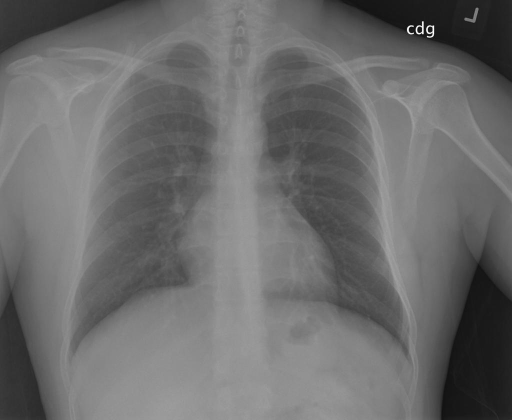

		 CXR2609_IM-1099-3001.png
2)



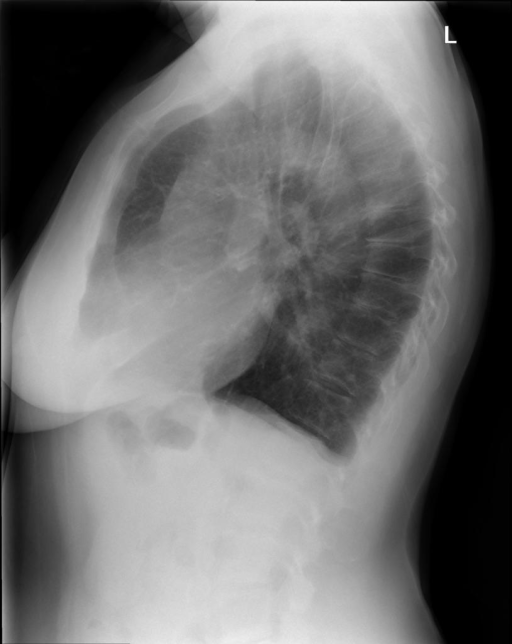

		 CXR2794_IM-1226-1002.png
3)



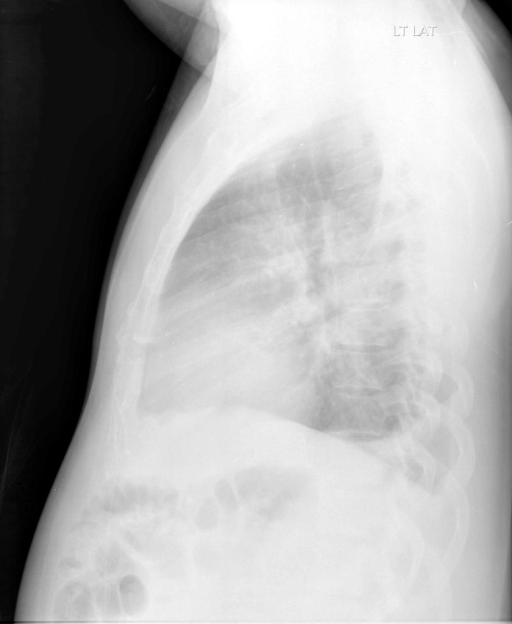

		 CXR3148_IM-1480-2001.png


In [ ]:
#showing random 3 sample images
np.random.seed(420)
for i in range(3): #print 5 sample images
  k = np.random.choice(range(imgCnt))
  image_file = os.listdir(extractedImageFolder)[k] 
  image = cv2.imread(os.path.join(extractedImageFolder,image_file)) #getting an image file
  print("%i)\n"%(i+1))
  cv2_imshow(image)
  print("\t\t",image_file) #the image file name

In [12]:
Image_count = []
for file in tqdm(os.listdir(extractedFolder + 'ecgen-radiology/')):
  if file.endswith(".xml"):
    k = extractedFolder + "ecgen-radiology/"
    path = k + file
    reportTree = et.parse(path)# parsing xml report
    imgtrees = reportTree.findall("parentImage")
    Image_count.append(len(imgtrees))

100%|██████████| 3955/3955 [00:43<00:00, 90.62it/s]  


In [13]:
print("The max no. of images associated with a report: %i"%(max(Image_count)))
print("The min no. of images associated with a report: %i"%(min(Image_count)))

The max no. of images associated with a report: 5
The min no. of images associated with a report: 0


In [14]:
values = pd.Series(Image_count).value_counts()


<bound method Series.keys of 2    3208
1     446
3     181
0     104
4      15
5       1
dtype: int64>

In [15]:
values.index

Int64Index([2, 1, 3, 0, 4, 5], dtype='int64')

2    3208
1     446
3     181
0     104
4      15
5       1
dtype: int64


([<matplotlib.patches.Wedge at 0x7fe9fd97c190>,
 [Text(-0.615071945989818, -0.911968476021128, '2'),
  Text(0.8135500865809883, 0.7403622468927401, '1'),
  Text(0.36103805128877065, 1.0390628111532079, '3'),
  Text(0.12399236482389782, 1.1432960655339357, '0'),
  Text(0.015528729362476134, 1.1498951511178692, '4'),
  Text(0.0009134477035733516, 1.1499996372231136, '5')],
 [Text(-0.47528286735576836, -0.7047029132890533, '81.1%'),
  Text(0.6286523396307636, 0.5720980998716627, '11.3%'),
  Text(0.2789839487231409, 0.8029121722547515, '4.6%'),
  Text(0.09703750290565916, 0.8947534425917757, '2.6%'),
  Text(0.01215291863150306, 0.899917944353115, '0.4%'),
  Text(0.0007148721158400142, 0.8999997160876541, '0.0%')])

Text(0.5, 1.0, 'image count distribution in report')

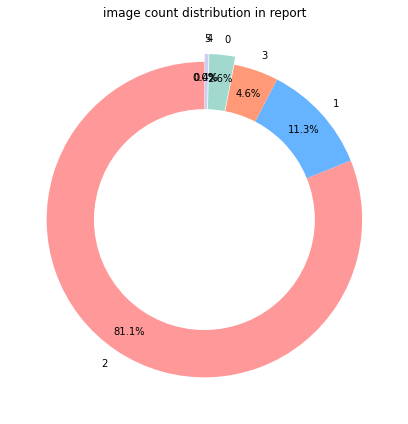

In [33]:
values = pd.Series(Image_count).value_counts()

print(values)
#define color palette to use
colors = ['#ff9999','#66b3ff', '#ff9977','#A2D9CE', '#CCCCFF','#DFFF00']


#explosion 
explode = (0,0,0,0.05,0.05,0.05)
#create pie chart to see the distribution of target variable of interest
plt.pie(values, colors = colors, labels=values.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
fig.set_size_inches(6,6)
# Equal aspect ratio ensures that pie is drawn as a circle 
plt.title("image count distribution in report") 
plt.tight_layout()
plt.show()

We can see that the maximum number of images associated with a report can be 5 while the minimum is 0. We will extract all the information part ie comparison, indication, findings and impression part of the report and the corresponding 2 images (we will take 2 images as input as 2 images are highest frequecy of being associated with a report) of the concerned report to a dataframe with xml report file name. For images more than 2, we will create new datapoint with new image and same info.

##Data Preprocessing

In [ ]:
columns = ["image_id1", "image_id2", "caption", "comparison", "indication", "findings", "impression","xml_File","height_img1","width_img1","height_img2","width_img2"]

In [ ]:
df_reports = pd.DataFrame(columns = columns)

In [ ]:
df_reports.head()

,image_id1,image_id2,caption,comparison,indication,findings,impression,xml_File,height_img1,width_img1,height_img2,width_img2


In [ ]:
img1 = [] #there are 2 images associated with a report
img2 = []
h1 = [] #there are 2 images associated with a report
w1 = []
h2 = [] #there are 2 images associated with a report
w2= []
#stores info
captions = []
comparisons = []
indications = []
findings = []
impressions = [] 
report_name = [] #stores xml file name
for file in tqdm(os.listdir(extractedFolder + 'ecgen-radiology/')):
    if file.endswith(".xml"):
        k = extractedFolder + "ecgen-radiology/"
        path = k + file
        mytree = et.parse(path)# parsing xml report
        comparision = mytree.find(".//AbstractText[@Label='COMPARISON']").text # extracting comaparison text
        indication = mytree.find(".//AbstractText[@Label='INDICATION']").text #extracting indication text
        finding = mytree.find(".//AbstractText[@Label='FINDINGS']").text # extracting findings text
        impression = mytree.find(".//AbstractText[@Label='IMPRESSION']").text  # extracting impression text

        mytree = et.parse(path)
        imgtrees = mytree.findall("parentImage")
        if len(imgtrees)==2:
          image_id1 = imgtrees[0].attrib['id']+".png"
          image_id2 = imgtrees[1].attrib['id']+".png"
          caption = '' if imgtrees[0].find('caption').text is None else imgtrees[0].find('caption').text
          # print(image_id1)
          # print(image_id2)
          # print(caption)
          filename1 = work_dir + 'data/images/extracted/' + image_id1
          image1 = cv2.imread(filename1) # reading image1          
     
          filename2 = work_dir + 'data/images/extracted/' + image_id2
          image2 = cv2.imread(filename2) # reading image2
          
          height1, width1, channels1 = image1.shape          
          height2, width2, channels2 = image2.shape
          
          img2.append(image_id2)
          img1.append(image_id1)
          h1.append(height1)
          w1.append(width1)
          h2.append(height2)
          w2.append(width2)
          captions.append(caption)
          comparisons.append(comparision)
          indications.append(indication)
          findings.append(finding)
          impressions.append(impression)
          report_name.append(file) #xml file name
         
        elif len(imgtrees)<2:
          try: #if the exception is raised means no image file name was found
            image_id1 = imgtrees[0].attrib['id']+".png"
            image_id2 =  np.nan
            caption = '' if imgtrees[0].find('caption').text is None else imgtrees[0].find('caption').text
            filename1 = work_dir + 'data/images/extracted/' + image_id1
            image1 = cv2.imread(filename1) # reading image1

            height1, width1, channels1 = image1.shape
            height2, width2 = np.nan, np.nan
            
          except:
            image_id1 = np.nan
            image_id2 =  np.nan
            height1, width1 = np.nan, np.nan
            height2, width2 = np.nan, np.nan
          
          img1.append(image_id1)
          img2.append(image_id2)
          h1.append(height1)
          w1.append(width1)
          h2.append(height2)
          w2.append(width2)
          captions.append(caption)
          comparisons.append(comparision)
          indications.append(indication)
          findings.append(finding)
          impressions.append(impression)
          report_name.append(file) #xml file name
        else: #if there are more than 2 images concerned with report
          for i in range(len(imgtrees)-1):
            image_id1 = imgtrees[i].attrib['id']+".png"
            image_id2 = imgtrees[i+1].attrib['id']+".png"
            caption = '' if imgtrees[i].find('caption').text is None else imgtrees[i].find('caption').text
            filename1 = work_dir + 'data/images/extracted/' + image_id1
            image1 = cv2.imread(filename1) # reading image1
            filename2 = work_dir + 'data/images/extracted/' + image_id2
            image2 = cv2.imread(filename2) # reading image2
            
            height1, width1, channels1 = image1.shape
            height2, width2, channels2 = image2.shape

            img1.append(image_id1)
            img2.append(image_id2)
            h1.append(height1)
            w1.append(width1)
            h2.append(height2)
            w2.append(width2)
            captions.append(caption)
            comparisons.append(comparision)
            indications.append(indication)
            findings.append(finding)
            impressions.append(impression)
            report_name.append(file) #xml file name

# print(img1)
# print(h1)
# print(w2)
dfreport = pd.DataFrame({"image_1":img1,"image_2":img2,"caption":captions,"comparison":comparisons,"indication":indications,
                   "findings":findings,"impression":impressions,"xml file name":report_name,"height1":h1,"width1":w1,"height2":h2,"width2":w2})


100%|██████████| 3955/3955 [00:58<00:00, 67.03it/s]


In [ ]:
dfreport.shape

(4169, 12)

In [ ]:
dfreport.to_csv('dfreport.csv', index=False)

In [34]:
df = pd.read_csv(work_dir + 'dfreport.csv', index_col=False)
df.shape

(4169, 12)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4169 entries, 0 to 4168
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_1        4065 non-null   object 
 1   image_2        3619 non-null   object 
 2   caption        4168 non-null   object 
 3   comparison     3509 non-null   object 
 4   indication     4076 non-null   object 
 5   findings       3606 non-null   object 
 6   impression     4134 non-null   object 
 7   xml file name  4169 non-null   object 
 8   height1        4065 non-null   float64
 9   width1         4065 non-null   float64
 10  height2        3619 non-null   float64
 11  width2         3619 non-null   float64
dtypes: float64(4), object(8)
memory usage: 391.0+ KB


In [36]:
df.head()
df.tail()

# Summary Statistics of Dataset
df.describe()


,image_1,image_2,caption,comparison,indication,findings,impression,xml file name,height1,width1,height2,width2
0,CXR3402_IM-1646-1001.png,CXR3402_IM-1646-2001.png,"Chest radiographs, 2 XXXX and lateral",XXXX,XXXX-year-old female with chest pain,The heart size and mediastinal contours appear...,No acute cardiopulmonary findings.,3402.xml,624.0,512.0,624.0,512.0
1,CXR3403_IM-1647-1001.png,CXR3403_IM-1647-2001.png,"Radiographs of the chest, 2 views, PA and late...",None.,XXXX-year-old female. Left chest pain. Right r...,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.,3403.xml,512.0,512.0,512.0,512.0
2,CXR3404_IM-1647-1001.png,CXR3404_IM-1647-2001.png,Xray Chest PA and Lateral,XXXX,chronic XXXX; left mastectomy,The heart is normal in size. The mediastinum i...,No acute disease.,3404.xml,512.0,512.0,532.0,512.0
3,CXR3406_IM-1647-1001.png,CXR3406_IM-1647-2001.png,"Chest radiographs, 2 XXXX and lateral",XXXX,XXXX-year-old female with XXXX pain left upper...,The heart size and mediastinal contours appear...,No acute cardiopulmonary findings.,3406.xml,420.0,512.0,624.0,512.0
4,CXR3405_IM-1647-1001.png,CXR3405_IM-1647-2001.png,"PA and Lateral Chest Radiograph XXXX, XXXX at ...","CT chest XXXX, XXXX",XXXX-year-old female with chest pain,The heart is normal size. The mediastinum is u...,No acute cardiopulmonary abnormality.,3405.xml,420.0,512.0,624.0,512.0


,image_1,image_2,caption,comparison,indication,findings,impression,xml file name,height1,width1,height2,width2
4164,CXR811_IM-2343-1001.png,CXR811_IM-2343-2001.png,"PA and Lateral Chest Radiograph XXXX, XXXX at ...","Chest radiograph XXXX, XXXX",XXXX-year-old female with chest pain,The heart is normal size. The mediastinum is u...,No acute cardiopulmonary abnormality.,811.xml,420.0,512.0,624.0,512.0
4165,CXR793_IM-2330-1001.png,CXR793_IM-2330-2001.png,Xray Chest PA and Lateral,NaN,"Dyspnea, shortness of breath, lightheadedness.",The XXXX examination consists of frontal and l...,No evidence of acute cardiopulmonary process.,793.xml,512.0,512.0,574.0,512.0
4166,CXR780_IM-2323-1001.png,CXR780_IM-2323-2001.png,PA and Lateral Chest,None available.,Preop bilateral leg gangrene.,Heart size is upper limits of normal. Mediasti...,Clear lungs. No acute cardiopulmonary findings.,780.xml,512.0,512.0,519.0,512.0
4167,CXR796_IM-2332-1001.png,CXR796_IM-2332-2001.png,"Radiographs of the chest, 2 views, dated XXXX,...",None.,XXXX-year-old female. Chest pain.,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.,796.xml,420.0,512.0,624.0,512.0
4168,CXR790_IM-2329-1001.png,CXR790_IM-2329-1002.png,CHEST 2V FRONTAL/LATERAL,None,XXXX LOSS,Both lungs are clear and expanded. Heart and m...,No active disease.,790.xml,509.0,512.0,509.0,512.0


,height1,width1,height2,width2
count,4065.000000,4065.0,3619.00000,3619.0
mean,504.751046,512.0,564.64189,512.0
std,74.680995,0.0,75.53680,0.0
min,362.000000,512.0,394.00000,512.0
25%,420.000000,512.0,512.00000,512.0
50%,512.000000,512.0,613.00000,512.0
75%,523.000000,512.0,624.00000,512.0
max,756.000000,512.0,873.00000,512.0


### Missing values and outliers

In [37]:
# Checking for Missing values in train dataset
print('Missing value in extracted report data: ',df.isnull().sum())

Missing value in extracted report data:  image_1          104
image_2          550
caption            1
comparison       660
indication        93
findings         563
impression        35
xml file name      0
height1          104
width1           104
height2          550
width2           550
dtype: int64


In [38]:
df.drop(df[(df['impression'].isnull())|(df['image_1'].isnull())|(df['height1'].isnull())|(df['width1'].isnull())].index,inplace=True)
df = df.reset_index(drop=True).copy()
print("%i datapoints were removed.\nFinal no. of datapoints: %i"%(4169-df.shape[0],df.shape[0]))

136 datapoints were removed.
Final no. of datapoints: 4033


we can use the same image file in image 1 for missing values in image 2

In [39]:
%%time
df.loc[df.image_2.isnull(),'image_2'] = df[df.image_2.isnull()]['image_1'].values
df.loc[df.height2.isnull(),'height2'] = df[df.height2.isnull()]['height1'].values
df.loc[df.width2.isnull(),'width2'] = df[df.width2.isnull()]['width1'].values

CPU times: user 7.23 ms, sys: 0 ns, total: 7.23 ms
Wall time: 6.66 ms


In [40]:
df.isnull().sum()

image_1            0
image_2            0
caption            1
comparison       611
indication        63
findings         521
impression         0
xml file name      0
height1            0
width1             0
height2            0
width2             0
dtype: int64

In [41]:
df.to_csv('df_report_final.csv', index=False)

In [42]:
df_final = pd.read_csv(work_dir + 'df_report_final.csv', index_col=False)
df_final.shape

(4033, 12)

<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'Height Plot')

Text(0, 0.5, 'Heights')

Text(0.5, 0, 'Images')

Text(0.5, 1.0, 'Width Plot')

Text(0, 0.5, 'Widths')

Text(0.5, 0, 'Images')

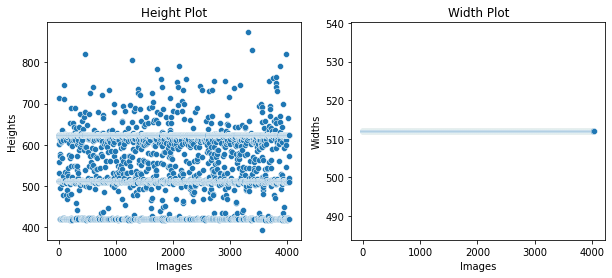

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Height Plot')
plt.ylabel('Heights')
plt.xlabel('Images')
sns.scatterplot(range(len(df_final.height1.values)), df_final.height2.values)
plt.subplot(122)
plt.title('Width Plot')
plt.ylabel('Widths')
plt.xlabel('Images')
sns.scatterplot(range(len(df_final.width1.values)), df_final.width2.values)

In [44]:
print("\n\nValue Counts of image 1 heights:\n")
print(df.height1.value_counts())
print("Value Counts of image 2 heights:\n")
print(df.height2.value_counts())



Value Counts of image 1 heights:

420.0    1130
512.0     926
624.0     674
511.0     234
618.0      87
         ... 
620.0       1
391.0       1
430.0       1
607.0       1
404.0       1
Name: height1, Length: 198, dtype: int64
Value Counts of image 2 heights:

624.0    1455
512.0     714
420.0     453
511.0     218
618.0      89
         ... 
450.0       1
687.0       1
466.0       1
760.0       1
666.0       1
Name: height2, Length: 262, dtype: int64


In [45]:
print("\n\nValue Counts of image 1 widths:\n")
print(df.width1.value_counts())
print("Value Counts of image 2 widths:\n")
print(df.width2.value_counts())



Value Counts of image 1 widths:

512.0    4033
Name: width1, dtype: int64
Value Counts of image 2 widths:

512.0    4033
Name: width2, dtype: int64


Height distribution is scattered but with most values in size 420 and 512.Width for both of the images have only 1 unique value for all datapoints and that is 512. Since pretrained models are modelled for square-sized images we can choose 512x512 as the specified size of the image. Hence we can resize all images into 512x512 shape. 

###Exploratory Data Analysis

In [46]:
def show_image_captions(df = df,image_folder = extractedImageFolder,sample = 5):
  k = df.sample(sample)
  i=1
  for index,row in k.iterrows():
    image_1 = cv2.imread(os.path.join(image_folder,row.get('image_1')))
    image_2 = cv2.imread(os.path.join(image_folder,row.get('image_2')))

    plt.figure(figsize = (12,8)) #setting the figure size
    plt.subplot(121) #first x-ray
    plt.imshow(image_1,aspect='auto')

    plt.subplot(122) #2nd x-ray
    plt.imshow(image_2, aspect = 'auto')
    print("%i)\n"%(i))
    i+=1
    plt.show() #printing the image
    print("\n","Caption: ",row.get('caption'))
    print("\n","Comparison: ",row.get('comparison'))
    print("\n","Indication: ",row.get('indication'))
    print("\n","Findings: ",row.get('findings'))
    print("\n","Impression: ",row.get('impression'),"\n\n","*"*150,"\n\n")

1)



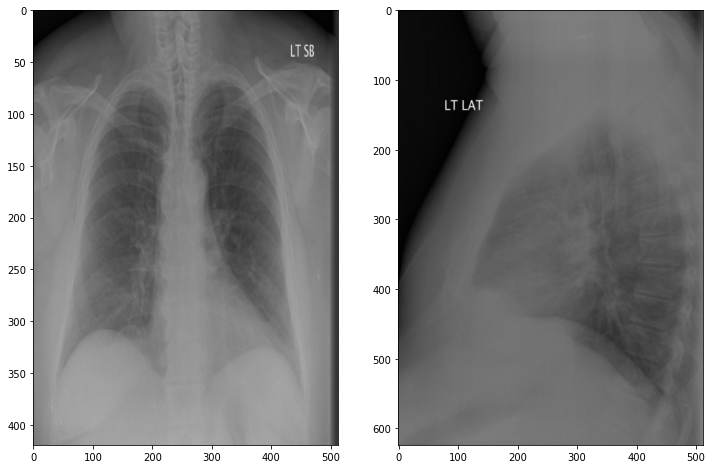


 Caption:  PA AND LATERAL VIEWS OF THE CHEST dated XXXX at XXXX hours 

 Comparison:  None.

 Indication:  XXXX

 Findings:  Cardiomediastinal silhouette is within normal limits in size and appearance. Pulmonary vascularity is unremarkable. There are prominent coarse interstitial markings throughout the lungs, with more focal streaky bibasilar opacities, seen only on the frontal XXXX, XXXX atelectasis. Negative for focal airspace disease or consolidation. Negative for pneumothorax or pleural effusion. Limited evaluation reveals the XXXX XXXX are grossly intact.

 Impression:  1. No acute cardiopulmonary abnormality. 

 ****************************************************************************************************************************************************** 


2)



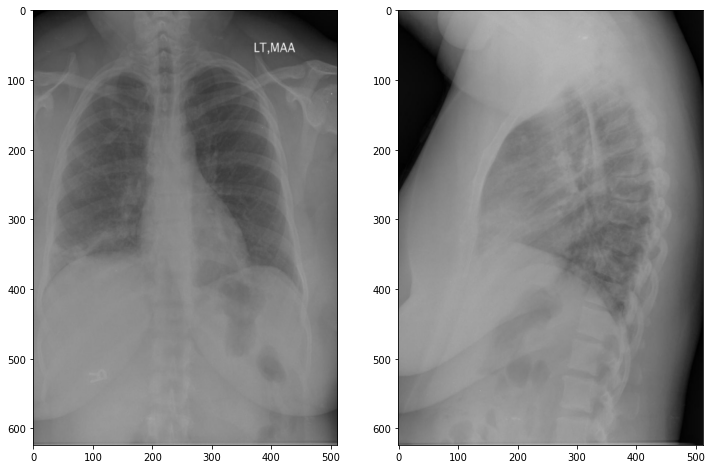


 Caption:  CHEST 2V FRONTAL/LATERAL 

 Comparison:  None

 Indication:  Shortness of breath

 Findings:  The heart is normal in size. The mediastinum is unremarkable. There is patchy infiltrate within normal right lower lobe. Mild XXXX opacities in the retrocardiac region. No large effusions or pneumothorax.

 Impression:  Patchy right lower lobe infiltrate as well as probable left basilar infiltrate versus atelectasis. 

 ****************************************************************************************************************************************************** 


3)



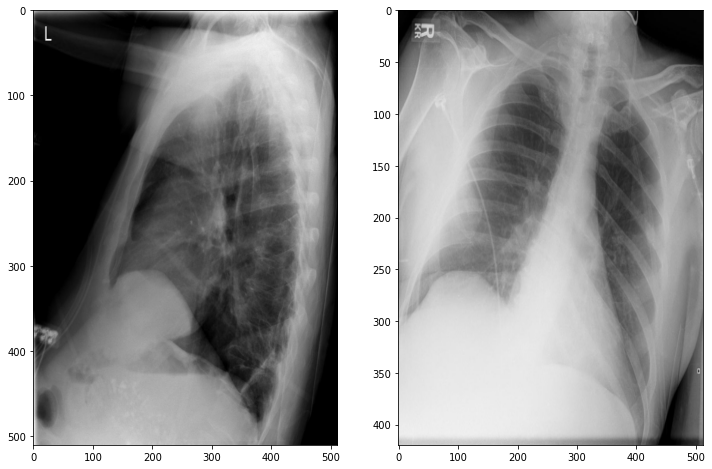


 Caption:  2 VIEW CHEST: XXXX, XXXX at XXXX hours.

 Comparison:  None

 Indication:  EtOH, diabetes, altered mental status

 Findings:  nan

 Impression:  Heart size is within normal limits. No edema. Bandlike scarring in the right base. No pleural effusion, lobar consolidation or pneumothorax. Multiple coarse calcifications in the epigastrium are seen on the lateral radiograph, not well localized on the frontal image. Could represent pancreatic parenchymal calcifications of chronic pancreatitis or old granulomatous sequela. 

 ****************************************************************************************************************************************************** 


4)



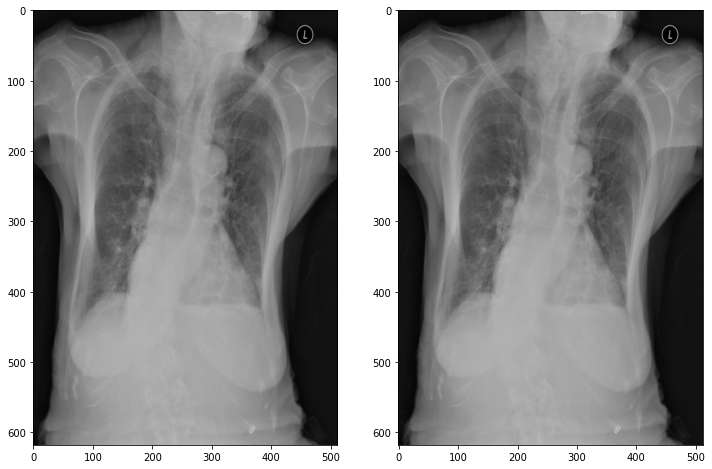


 Caption:  CHEST (PA AND LATERAL)

 Comparison:  XXXX, XXXX.

 Indication:  XXXX-year-old female status post XXXX.

 Findings:  Stable appearance of the cardiomediastinal silhouette. The aorta is calcified and tortuous. There is dextroscoliosis of the thoracolumbar spine. Multiple thoracic XXXX deformities appear unchanged. There is no displaced rib fracture identified. There is no pneumothorax or large pleural effusion. Stable changes of chronic lung disease with flattening of the left hemidiaphragm. There is mild right basilar airspace disease which may represent atelectasis versus infiltrate.

 Impression:  1. No acute posttraumatic finding. 2. Mild right basilar airspace consolidation may represent atelectasis versus infiltrate. 3. Changes of chronic lung disease. 

 ****************************************************************************************************************************************************** 


5)



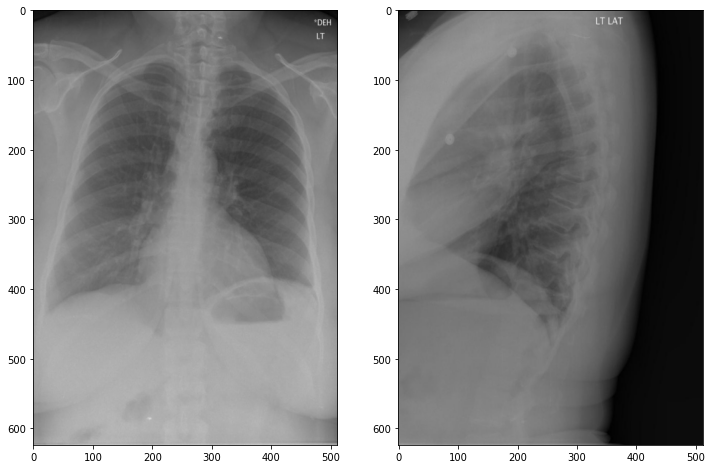


 Caption:  Chest radiographs, 2 XXXX and lateral 

 Comparison:  XXXX, XXXX.

 Indication:  XXXX-year-old woman, short of breath.

 Findings:  Heart size within normal limits. Negative for focal pulmonary consolidation, pleural effusion, or pneumothorax. Mild degenerative changes thoracic spine.

 Impression:  No acute abnormality. 

 ****************************************************************************************************************************************************** 




In [47]:
show_image_captions()

###Wordcloud

In [65]:
def show_wordcloud(data, title = None):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, 
                          background_color = 'white',
                          max_words=800,
                          max_font_size=60,
                          scale=3,
                          collocations=False,
                          random_state=1 ).generate(' '.join(data.astype(str)))

    fig = plt.figure(1, figsize=(12, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

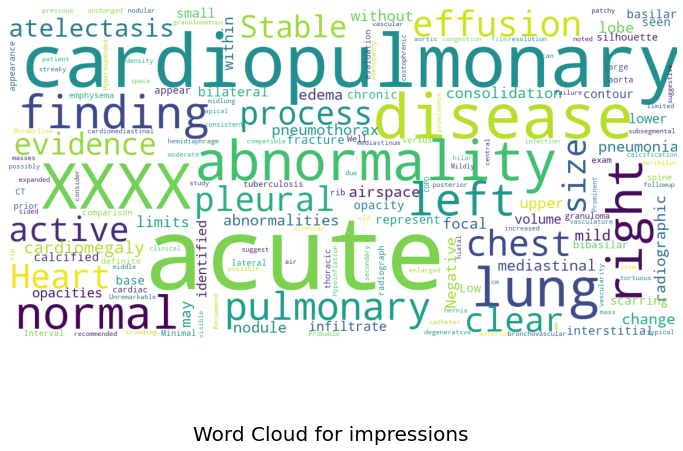

In [66]:
show_wordcloud(df_final['impression'], "Word Cloud for impressions")

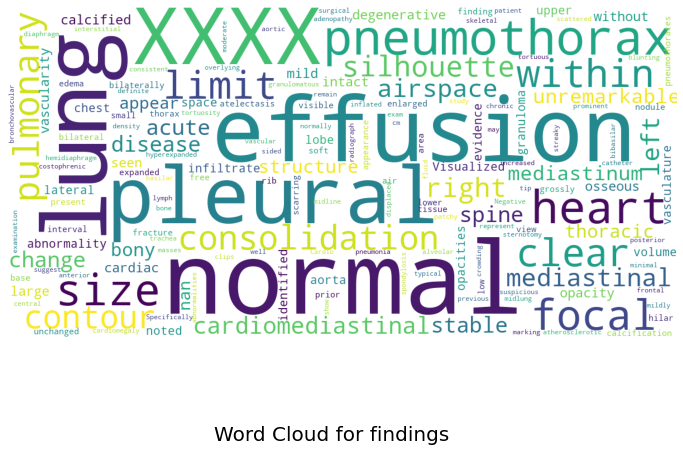

In [67]:
show_wordcloud(df_final['findings'], "Word Cloud for findings")

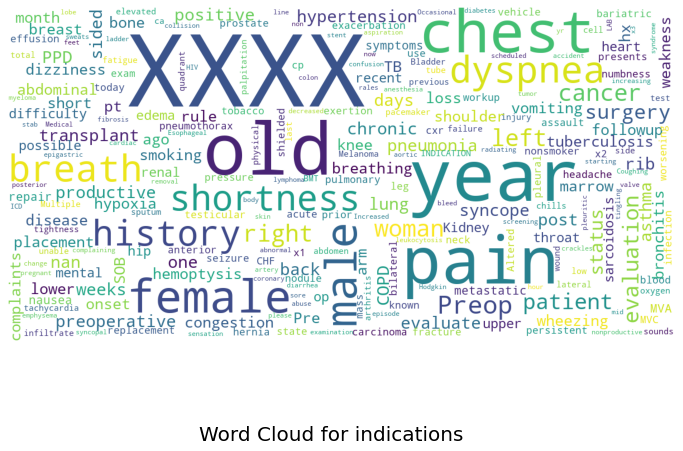

In [68]:
show_wordcloud(df_final['indication'], "Word Cloud for indications")

##Train & Test Split

In [75]:
df_final['image_1'] = df_final['image_1'].apply(lambda row: os.path.join(extractedImageFolder,row))
df_final['image_2'] = df_final['image_2'].apply(lambda row: os.path.join(extractedImageFolder,row))

In [76]:
df_final['impression'].value_counts()

No acute cardiopulmonary abnormality.                                                                           312
No active disease.                                                                                              134
No acute cardiopulmonary findings.                                                                              119
No acute cardiopulmonary abnormalities.                                                                         117
No acute disease.                                                                                               112
                                                                                                               ... 
Question prior right upper lobe resection, no acute abnormality.                                                  1
Probable mild cardiomegaly, without evidence of acute failure. No focal airspace disease. .                       1
Heart size is normal and lungs are clear. No effusions, pneumonia, or pn

In [77]:
df_report_final = df_final.drop_duplicates(subset = ['xml file name'])

In [78]:
df_report_final.shape

(3820, 12)

In [79]:
df_report_final['counts'] = df_report_final['impression'].map(df_report_final['impression'].value_counts())

In [80]:
df_report_final.head()

,image_1,image_2,caption,comparison,indication,findings,impression,xml file name,height1,width1,height2,width2,counts
0,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,"Chest radiographs, 2 XXXX and lateral",XXXX,XXXX-year-old female with chest pain,The heart size and mediastinal contours appear...,No acute cardiopulmonary findings.,3402.xml,624.0,512.0,624.0,512.0,111
1,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,"Radiographs of the chest, 2 views, PA and late...",None.,XXXX-year-old female. Left chest pain. Right r...,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.,3403.xml,512.0,512.0,512.0,512.0,30
2,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,Xray Chest PA and Lateral,XXXX,chronic XXXX; left mastectomy,The heart is normal in size. The mediastinum i...,No acute disease.,3404.xml,512.0,512.0,532.0,512.0,109
3,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,"Chest radiographs, 2 XXXX and lateral",XXXX,XXXX-year-old female with XXXX pain left upper...,The heart size and mediastinal contours appear...,No acute cardiopulmonary findings.,3406.xml,420.0,512.0,624.0,512.0,111
4,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,/content/gdrive/My Drive/MSDS/458-ANN/Assignme...,"PA and Lateral Chest Radiograph XXXX, XXXX at ...","CT chest XXXX, XXXX",XXXX-year-old female with chest pain,The heart is normal size. The mediastinum is u...,No acute cardiopulmonary abnormality.,3405.xml,420.0,512.0,624.0,512.0,301


In [93]:
counteq1_df =  df_report_final[df_report_final['counts'] > 1]
counteq1_df.shape

(2194, 13)

In [94]:
counteq1_df =  df_report_final[df_report_final['counts'] == 1]
countgt1_df =  df_report_final[df_report_final['counts'] > 1]
test_counteq1_df = counteq1_df.sample(int(0.2*counteq1_df.shape[0]),random_state = 42)
df_train, df_test = train_test_split(countgt1_df, test_size=0.2, stratify=countgt1_df['impression'],random_state = 42)
df_train = pd.concat([df_train, counteq1_df], axis=0)
df_test = pd.concat([df_test, test_counteq1_df], axis=0)
df_train.shape[0],df_test.shape[0]

(3381, 764)

In [100]:
#split train and validation set
dftrain, df_val = train_test_split(df_train, test_size=0.1, random_state = 42)

In [102]:
dftrain.shape[0],df_val.shape[0]

(3042, 339)

In [103]:
dftrain['impression'].value_counts()

No acute cardiopulmonary abnormality.                                                                                                                                                                                                                                                                                                                                          209
No active disease.                                                                                                                                                                                                                                                                                                                                                              92
No acute cardiopulmonary findings.                                                                                                                                                                                                                                

In [104]:
df_val['impression'].value_counts()

No acute cardiopulmonary abnormality.                                                                                                                                                                                       32
No acute disease.                                                                                                                                                                                                           12
No active disease.                                                                                                                                                                                                           9
No acute cardiopulmonary abnormalities.                                                                                                                                                                                      9
No acute cardiopulmonary findings.                                                                          

In [105]:
df_test['impression'].value_counts()

No acute cardiopulmonary abnormality.                                                                                                                                                                                                                                                                       60
No active disease.                                                                                                                                                                                                                                                                                          26
No acute cardiopulmonary abnormalities.                                                                                                                                                                                                                                                                     23
No acute disease.                                                                          

In [106]:
dftrain.to_pickle('train')
df_val.to_pickle('val')
df_test.to_pickle('test')